In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pydotplus
import keras
from matplotlib.text import Text
from keras.models import Sequential
from keras.layers import Dropout, Dense, Activation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import learning_curve
%matplotlib inline

Using TensorFlow backend.
//anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# Shows first five rows of data
df = pd.read_csv('bank.csv')
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
# Shows the amount of rows and columns of the dataset
df.shape

(5000, 14)

In [4]:
# All columns consist of numerical data so they don't need to be adjusted for modelling
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [5]:
# Shows amount of columns with missing data, there are none so this does not need to be cleaned for modelling
df.isnull().sum().sort_values(ascending=False).head(14)

CreditCard            0
Online                0
CD Account            0
Securities Account    0
Personal Loan         0
Mortgage              0
Education             0
CCAvg                 0
Family                0
ZIP Code              0
Income                0
Experience            0
Age                   0
ID                    0
dtype: int64

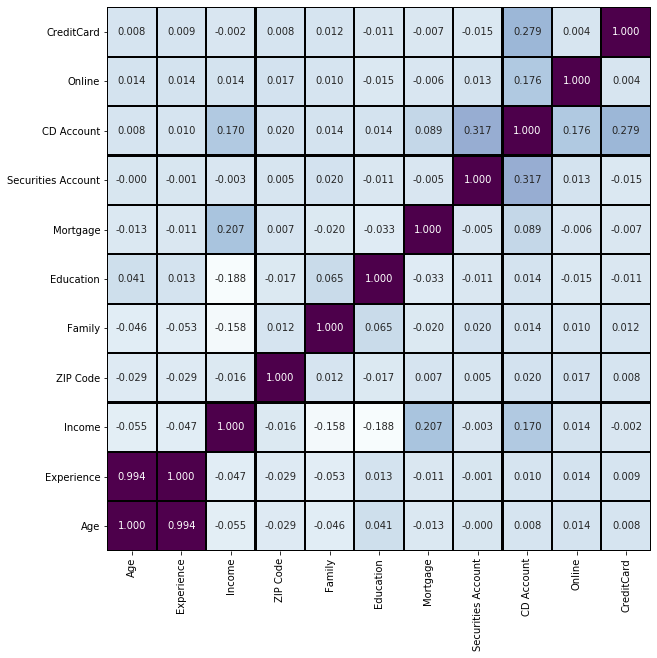

In [6]:
# Creates a Heatmap for all variables
corr = df.drop(['Personal Loan', 'ID', 'CCAvg'], 1) .corr()
df.corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(corr, annot=True, fmt=".3f", linewidths=1.1, square = True, cmap = 'BuPu', linecolor = 'black', cbar=False );
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.invert_yaxis()

In [7]:
# Shows amount of records if dependent variable 'Credit Card' is being used or not,
# values are already set to binary so this does not to be adjusted for modelling however,
# the sample size is highly imbalanced with the data for value 0 being more than double 1
print(df['CreditCard'].value_counts())

0    3530
1    1470
Name: CreditCard, dtype: int64


In [8]:
# Create functions to split credit card values
count_class_0, count_class_1 = df.CreditCard.value_counts()

In [9]:
# Create dataframes for split credit card values
df_class_0 = df[df['CreditCard'] == 0]
df_class_1 = df[df['CreditCard'] == 1]

In [10]:
# Create dataframe using Credit Card values to adjust data to be randomly under sampled,
# so it can be balanced for modelling
df_class_0_under = df_class_0.sample(count_class_1)
df_undersample = pd.concat([df_class_0_under, df_class_1], axis=0)
print('Random under-sampling:')
print(df_undersample.CreditCard.value_counts())

# sample size for both credit card values are now equal

Random under-sampling:
1    1470
0    1470
Name: CreditCard, dtype: int64


In [11]:
# Sample size decreased fom 5000 to 2940
df_undersample.shape

(2940, 14)

(11.0, 0.0)

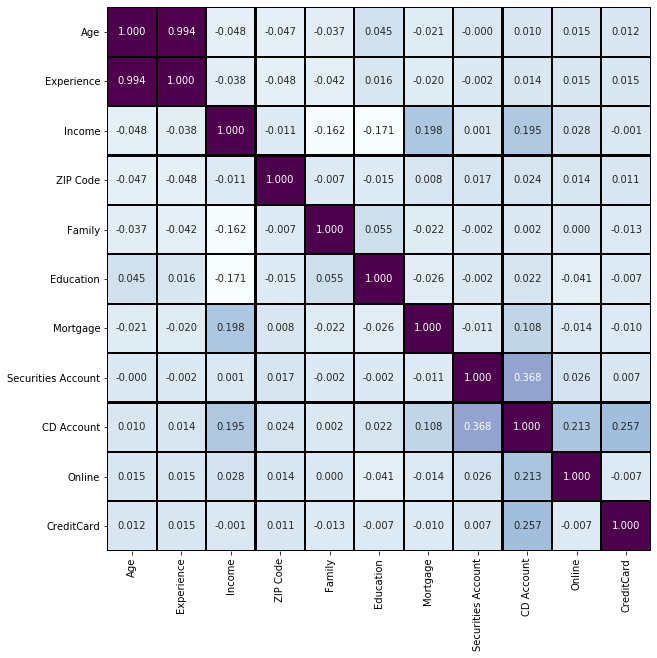

In [12]:
# Creates a Heatmap for all variables
corr = df_undersample.drop(['Personal Loan', 'ID', 'CCAvg'], 1) .corr()
df_undersample.corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(corr, annot=True, fmt=".3f", linewidths=1.1, square = True, cmap = 'BuPu', linecolor = 'black', cbar=False );
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
#ax.invert_yaxis()

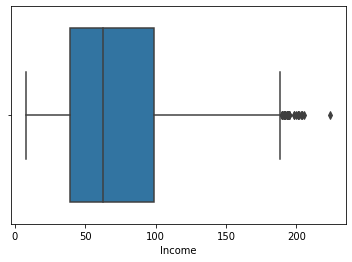

In [13]:
# Shows outlier values based on income values
sns.boxplot(x=df_undersample['Income'])

In [14]:
# Creates tukey outlier detection
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])
    return outlier_indices, outlier_values

In [15]:
# Shows exact values of outliers for income values
tukey_indices, tukey_values = find_outliers_tukey(df_undersample['Income'])
print(np.sort(tukey_values))

[190 190 190 190 190 191 191 191 191 191 191 191 191 191 192 192 192 192
 192 193 193 193 193 194 194 194 194 194 194 195 195 195 195 195 195 195
 195 198 198 200 201 201 201 202 203 204 204 205 224]


In [16]:
# Seperates credit card data from other features for Histogram
notcard = df_undersample.drop('CreditCard', 1)
card = df_undersample.CreditCard

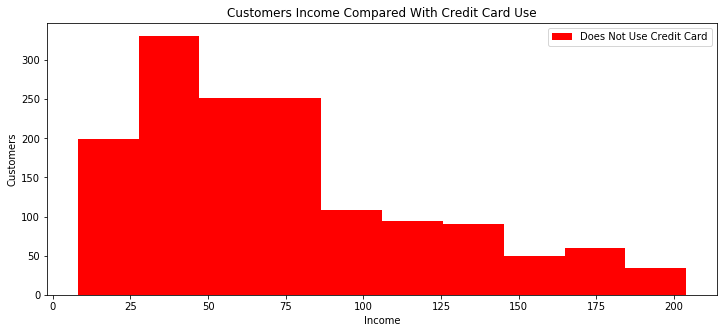

In [17]:
# Creates a Histogram for below variable
def plot_histogram_dv(x,y):
    plt.hist(list(x[y==0]), color='r', alpha=1.0, label='Does Not Use Credit Card')
    plt.title("Customers Income Compared With Credit Card Use".format(var_name=x.name))
    plt.xlabel("Income")
    plt.ylabel("Customers")
    plt.legend(loc='upper right')
    plt.show()
plt.rcParams["figure.figsize"] = [12,5]
plot_histogram_dv(notcard['Income'], card)

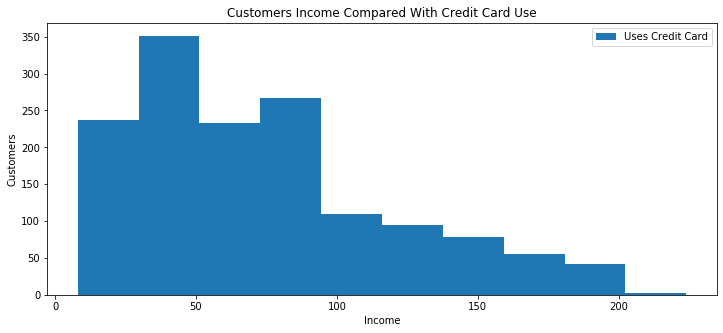

In [18]:
# Creates a Histogram for below variable
def plot_histogram_dv(x,y):
    plt.hist(list(x[y==1]), alpha=1.0, label='Uses Credit Card')
    plt.title("Customers Income Compared With Credit Card Use".format(var_name=x.name))
    plt.xlabel("Income")
    plt.ylabel("Customers")
    plt.legend(loc='upper right')
    plt.show()
plt.rcParams["figure.figsize"] = [12,5]
plot_histogram_dv(notcard['Income'], card)

In [19]:
# Removing columns that aren't going to be used for inputs
dropped = df_undersample.drop(columns=['Online','CD Account','Securities Account','Personal Loan','Mortgage','CCAvg','ZIP Code','ID','Experience','Age','Education', 'Income'])
dropped

,Family,CreditCard
4202,3,0
4132,1,0
1055,1,0
2969,2,0
3584,1,0
...,...,...
4984,4,1
4988,1,1
4990,4,1
4991,1,1


In [20]:
# Grouping the income values so they can be presented in a Heatmap
bins = [0,22.5,45,67.5,90,112.5,135,157.5,180,202.5,225]
group_names = ['0-22.5K','22.5-45K', '45-67.5K', '67.5-90K', '90-112.5K', '112.5-135K', '135-157.5K', '157.5-180K','180-202.5K','202.5-225K']
df_undersample['Income Boundary'] = pd.cut(df_undersample['Income'], bins, labels = group_names)
df_undersample

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,Income Boundary
4202,4203,35,9,82,95064,3,0.9,2,0,0,0,0,1,0,67.5-90K
4132,4133,61,36,133,90266,1,2.6,1,0,0,0,0,1,0,112.5-135K
1055,1056,31,6,62,95630,1,1.0,1,0,0,1,0,1,0,45-67.5K
2969,2970,43,18,60,95039,2,2.2,3,115,0,0,0,0,0,45-67.5K
3584,3585,63,37,15,92121,1,0.8,2,115,0,0,0,1,0,0-22.5K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4984,4985,27,1,98,94043,4,2.3,3,0,0,0,0,0,1,90-112.5K
4988,4989,34,8,85,95134,1,2.5,1,136,0,0,0,0,1,67.5-90K
4990,4991,55,25,58,95023,4,2.0,3,219,0,0,0,0,1,45-67.5K
4991,4992,51,25,92,91330,1,1.9,2,100,0,0,0,0,1,90-112.5K


In [21]:
# Income column values grouped, also shows combined values for family and credit card for each group,
# greater amount of customers income between 0-100k than above as well as family size and credit cards
bin = dropped.groupby(pd.cut(df_undersample["Income"], np.arange(0, 225+22.5, 22.5))).sum()
bin.head(11)

,Family,CreditCard
Income,,
"(0.0, 22.5]",744,153
"(22.5, 45.0]",1948,378
"(45.0, 67.5]",1276,231
"(67.5, 90.0]",1460,292
"(90.0, 112.5]",509,111
"(112.5, 135.0]",475,128
"(135.0, 157.5]",256,66
"(157.5, 180.0]",296,67
"(180.0, 202.5]",176,42


In [22]:
# Dataframe for  plotting a Heatmap for below variables
couple_columns = df_undersample[['CreditCard','Family', 'Income Boundary']]
couple_columns.head()

,CreditCard,Family,Income Boundary
4202,0,3,67.5-90K
4132,0,1,112.5-135K
1055,0,1,45-67.5K
2969,0,2,45-67.5K
3584,0,1,0-22.5K


In [23]:
# Values for Heatmap
probability = couple_columns.groupby(['Income Boundary', 'Family']).mean()
probability.head(10)

CreditCard
Income Boundary Family            
0-22.5K         1         0.481481
                2         0.493671
                3         0.468085
                4         0.582418
22.5-45K        1         0.504950
                2         0.553459
                3         0.461111
                4         0.472973
45-67.5K        1         0.454545
                2         0.457447

In [24]:
# Reset index of values for Heatmap
probability = probability.reset_index()
probability.head()

,Income Boundary,Family,CreditCard
0,0-22.5K,1,0.481481
1,0-22.5K,2,0.493671
2,0-22.5K,3,0.468085
3,0-22.5K,4,0.582418
4,22.5-45K,1,0.504950


In [25]:
# Setting rows and columns for Heatmap pivot
probability.pivot('Income Boundary', 'Family','CreditCard').head()

Family,1,2,3,4
Income Boundary,,,,
0-22.5K,0.481481,0.493671,0.468085,0.582418
22.5-45K,0.504950,0.553459,0.461111,0.472973
45-67.5K,0.454545,0.457447,0.514493,0.475177
67.5-90K,0.510638,0.642857,0.481203,0.449102
90-112.5K,0.542857,0.460526,0.378378,0.545455


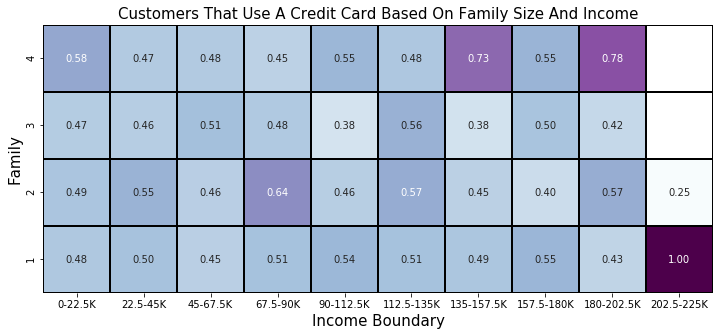

In [26]:
# Creates a Heatmap showing the amount of customers that use a credit card based on inputs
plt.figure(figsize=(12,10))
pivot_table = probability.pivot('Family', 'Income Boundary','CreditCard')
plt.xlabel('Family Size', size = 15)
plt.ylabel('Income', size = 15)
plt.title('Customers That Use A Credit Card Based On Family Size And Income', size = 15)
ax = sns.heatmap(pivot_table, annot=True, fmt=".2f", linewidths=1.1, square = True, cmap = 'BuPu', linecolor = 'black', cbar=False );
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.invert_yaxis()

In [167]:
# Inputs are the independent variables that affect the target, which is a dependent variable
# Imbalanced sample dataset commented out below
# inputs = df[['Family', 'Income']]
# target = df['CreditCard']
inputs = df_undersample[['Family', 'Income']]
target = df_undersample['CreditCard']

In [196]:
# Training/Test data split
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2)

In [197]:
# Amount of samples used in each split
len(X_train), len(y_train), len(X_test), len(y_test)

(2352, 2352, 588, 588)

In [198]:
# Creates decision tree classifier model
dt = tree.DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 5)
dt.fit(X_train, y_train) #call the function to fit to the data (training the model)
print('Accuracy on the training subset: {:.2f}'.format(dt.score(X_train, y_train)))
print('Accuracy on the test subset: {:.2f}'.format(dt.score(X_test, y_test)))

Accuracy on the training subset: 0.52
Accuracy on the test subset: 0.48


In [199]:
# Accuracy breakdown
dt_pred = dt.predict(X_test)
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       0.40      0.10      0.16       289
           1       0.50      0.85      0.63       299

    accuracy                           0.48       588
   macro avg       0.45      0.48      0.39       588
weighted avg       0.45      0.48      0.40       588



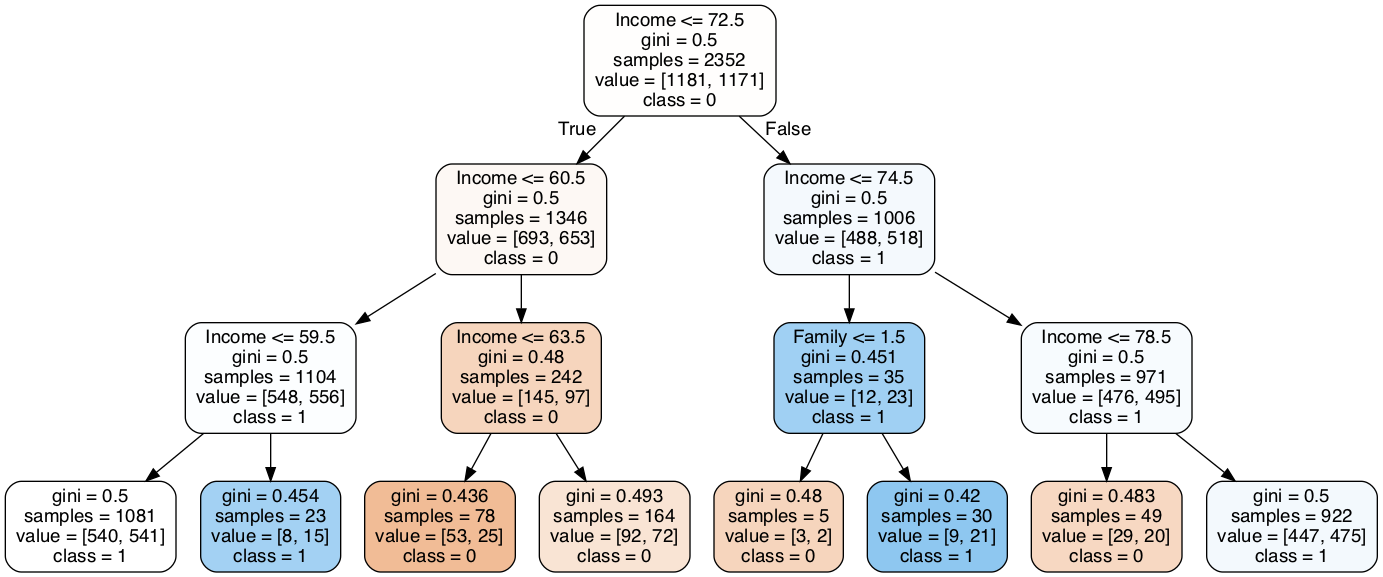

In [200]:
# Shows decision tree output, class is the target variable (Credit Card)
dot_data = StringIO()
tree.export_graphviz(dt, out_file = dot_data, feature_names = inputs.columns, class_names = ['0','1'], filled = True, rounded = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())


In [201]:
# Create a curve plot to show the training and test data accuracy based on sample amount
train_sizes, train_scores, test_scores = learning_curve(estimator=dt,
                                                       X=inputs,
                                                       y=target,
                                                       train_sizes=np.linspace(0.01, 1.0, 10),
                                                       cv=10)

print(train_scores)
# Mean value of accuracy against training data
train_mean = np.mean(train_scores, axis=1)
print(train_mean)
print(train_sizes)
# Standard deviation of training accuracy per number of training samples
train_std = np.std(train_scores, axis=1)

# Same as above for test data
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [0.89331533 0.89331533 0.89331533 0.89331533 0.89331533 0.89331533
  0.89331533 0.89331533 0.89331533 0.89331533]
 [0.746614   0.746614   0.74774266 0.746614   0.74717833 0.746614
  0.748307   0.746614   0.746614   0.746614  ]
 [0.64420746 0.6446922  0.64566166 0.64372273 0.643238   0.64420746
  0.64420746 0.64517693 0.64517693 0.64372273]
 [0.56796941 0.56542056 0.56881903 0.56966865 0.57051827 0.56924384
  0.56839422 0.57264231 0.56669499 0.56584537]
 [0.518

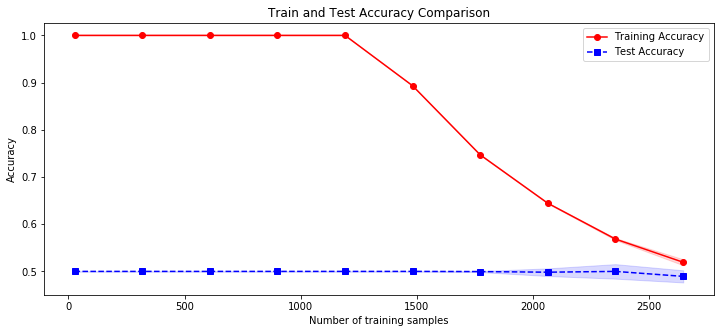

In [202]:
# Plot training accuracies 
plt.plot(train_sizes, train_mean, color='red', marker='o', label='Training Accuracy')
# Plot the variance of training accuracies
plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='red')

# Plot for test data as training data
plt.plot(train_sizes, test_mean, color='blue', linestyle='--', marker='s', 
        label='Test Accuracy')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='blue')

plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Train and Test Accuracy Comparison")
plt.show()

(2.0, 0.0)

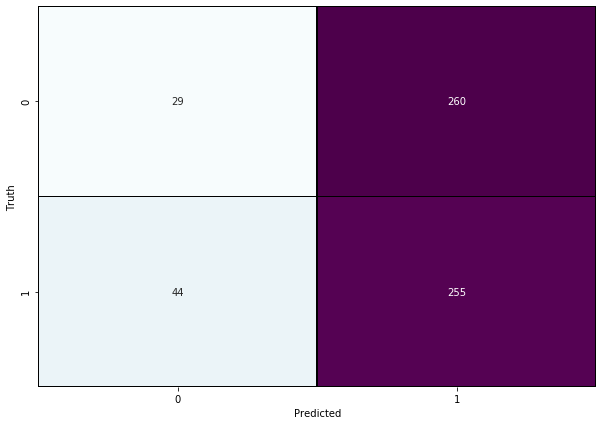

In [203]:
# Shows confusion matrix of dt on test samples of credit value
# top left = TN, top right = FP, bottom left = FN, bottom right = TP
cm = confusion_matrix(y_test, dt_pred)
plt.figure(figsize=(10,7))
axis = sns.heatmap(cm, annot=True, cmap = 'BuPu', linewidths=.5, linecolor = 'black', fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
bottom, top = axis.get_ylim()
axis.set_ylim(bottom + 0.5, top - 0.5)

In [225]:
# Training/Test data split
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2)

In [226]:
# Creates random forest classifier model
rf = RandomForestClassifier(10, max_depth = 3)
rf.fit(X_train, y_train) #call the function to fit to the data (training the model)
print('Accuracy on the training subset: {:.2f}'.format(rf.score(X_train, y_train)))
print('Accuracy on the test subset: {:.2f}'.format(rf.score(X_test, y_test)))

Accuracy on the training subset: 0.54
Accuracy on the test subset: 0.46


In [227]:
# Accuracy breakdown, high precision low recall
rf_pred = rf.predict(X_test)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.49      0.33      0.39       312
           1       0.44      0.61      0.51       276

    accuracy                           0.46       588
   macro avg       0.46      0.47      0.45       588
weighted avg       0.47      0.46      0.45       588



In [228]:
# Create a curve plot to show the training and test data accuracy based on sample amount
train_sizes, train_scores, test_scores = learning_curve(estimator=rf,
                                                       X=inputs,
                                                       y=target,
                                                       train_sizes=np.linspace(0.01, 1.0, 10),
                                                       cv=10)

print(train_scores)
# Mean value of accuracy against training data
train_mean = np.mean(train_scores, axis=1)
print(train_mean)
print(train_sizes)
# Standard deviation of training accuracy per number of training samples
train_std = np.std(train_scores, axis=1)

# Same as above for test data
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [0.89399055 0.89331533 0.89399055 0.89399055 0.89399055 0.89399055
  0.89331533 0.89399055 0.89399055 0.89399055]
 [0.74774266 0.746614   0.751693   0.746614   0.746614   0.746614
  0.74774266 0.748307   0.748307   0.74774266]
 [0.643238   0.64614639 0.64857004 0.64129908 0.643238   0.64517693
  0.64711585 0.64517693 0.6446922  0.643238  ]
 [0.57391674 0.56839422 0.56627018 0.57391674 0.56966865 0.56924384
  0.5722175  0.57349193 0.5768904  0.5675446 ]
 [0.538

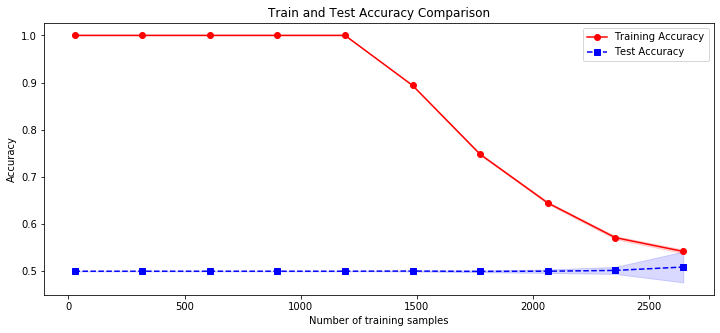

In [229]:
# Plot training accuracies 
plt.plot(train_sizes, train_mean, color='red', marker='o', label='Training Accuracy')
# Plot the variance of training accuracies
plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='red')

# Plot for test data as training data
plt.plot(train_sizes, test_mean, color='blue', linestyle='--', marker='s', 
        label='Test Accuracy')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='blue')

plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Train and Test Accuracy Comparison")
plt.show()

(2.0, 0.0)

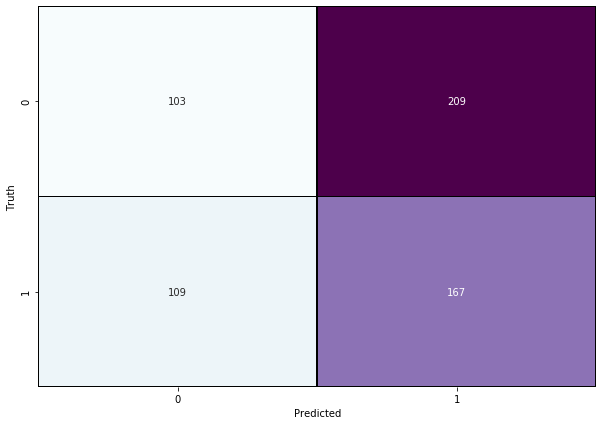

In [230]:
# Shows confusion matrix of rf on test samples of credit card value
# top left = TN, top right = FP, bottom left = FN, bottom right = TP
cm1 = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(10,7))
axis = sns.heatmap(cm1, annot=True, cmap = 'BuPu', linewidths=.5, linecolor = 'black', fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
bottom, top = axis.get_ylim()
axis.set_ylim(bottom + 0.5, top - 0.5)

In [242]:
# Training/Test data split
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2)

In [243]:
# Creates logistic regression classifier model
lr = LogisticRegression(solver='lbfgs') 
lr.fit(X_train, y_train) #call the function to fit to the data (training the model)
print('Accuracy on the training subset: {:.2f}'.format(lr.score(X_train, y_train)))
print('Accuracy on the test subset: {:.2f}'.format(lr.score(X_test, y_test)))

Accuracy on the training subset: 0.51
Accuracy on the test subset: 0.47


In [244]:
# Accuracy breakdown
lr_pred = lr.predict(X_test)
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.53      0.13      0.21       316
           1       0.46      0.87      0.60       272

    accuracy                           0.47       588
   macro avg       0.50      0.50      0.41       588
weighted avg       0.50      0.47      0.39       588



In [245]:
# Create a curve plot to show the training and test data accuracy based on sample amount
train_sizes, train_scores, test_scores = learning_curve(estimator=lr,
                                                       X=inputs,
                                                       y=target,
                                                       train_sizes=np.linspace(0.01, 1.0, 10),
                                                       cv=10, shuffle=True)

print(train_scores)
# Mean value of accuracy against training data
train_mean = np.mean(train_scores, axis=1)
print(train_mean)
print(train_sizes)
# Standard deviation of training accuracy per number of training samples
train_std = np.std(train_scores, axis=1)

# Same as above for test data
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

[[0.42307692 0.53846154 0.73076923 0.46153846 0.69230769 0.61538462
  0.73076923 0.69230769 0.69230769 0.61538462]
 [0.5362776  0.53943218 0.47318612 0.49211356 0.52365931 0.5362776
  0.53312303 0.55520505 0.55835962 0.5362776 ]
 [0.50986842 0.51480263 0.52138158 0.55098684 0.51151316 0.52631579
  0.50164474 0.51644737 0.53125    0.54769737]
 [0.51612903 0.51501669 0.5083426  0.53726363 0.52502781 0.5083426
  0.50389321 0.5105673  0.52502781 0.53058954]
 [0.50420168 0.52436975 0.49915966 0.52016807 0.53697479 0.52689076
  0.51680672 0.52436975 0.50588235 0.53613445]
 [0.5172181  0.51924375 0.49898717 0.51654288 0.52059419 0.51586766
  0.53207292 0.52194463 0.51114112 0.52869683]
 [0.52031603 0.51410835 0.50790068 0.5214447  0.52031603 0.50282167
  0.52595937 0.51297968 0.50733634 0.52257336]
 [0.51866214 0.50654387 0.51187591 0.51478429 0.51526903 0.50460494
  0.51090645 0.51042172 0.50315075 0.51042172]
 [0.51869159 0.51274427 0.50934579 0.50807137 0.51019541 0.5097706
  0.50552251 0.

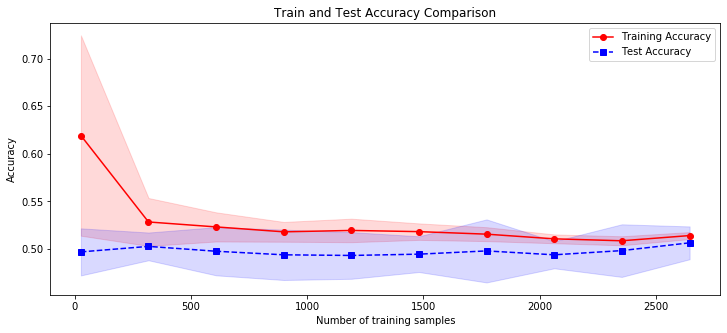

In [246]:
# Plot training accuracies 
plt.plot(train_sizes, train_mean, color='red', marker='o', label='Training Accuracy')
# Plot the variance of training accuracies
plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='red')

# Plot for test data as training data
plt.plot(train_sizes, test_mean, color='blue', linestyle='--', marker='s', 
        label='Test Accuracy')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='blue')

plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Train and Test Accuracy Comparison")
plt.show()

(2.0, 0.0)

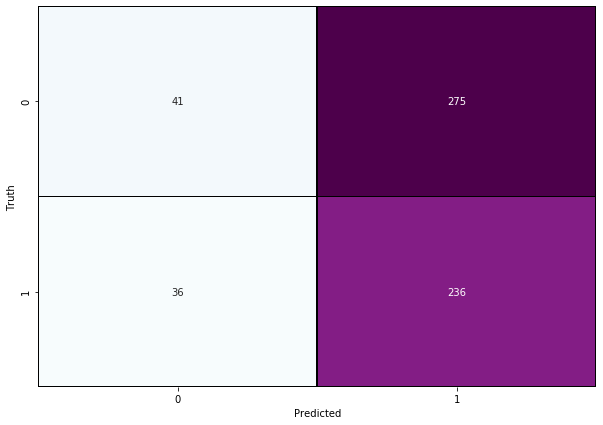

In [247]:
# Shows confusion matrix of lr model on test samples of credit card value
# top left = TN, top right = FP, bottom left = FN, bottom right = TP
cm2 = confusion_matrix(y_test, lr_pred)
plt.figure(figsize=(10,7))
axis = sns.heatmap(cm2, annot=True, cmap = 'BuPu', linewidths=.5, linecolor = 'black', fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
bottom, top = axis.get_ylim()
axis.set_ylim(bottom + 0.5, top - 0.5)

In [276]:
# Training/Test data split
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2)

In [277]:
# Creates support vector machine classifier model
svm = SVC(gamma=0.001, C=1)
svm.fit(X_train, y_train) #call the function to fit to the data (training the model)
print('Accuracy on the training subset: {:.2f}'.format(svm.score(X_train, y_train)))
print('Accuracy on the test subset: {:.2f}'.format(svm.score(X_test, y_test)))

Accuracy on the training subset: 0.52
Accuracy on the test subset: 0.50


In [278]:
# Accuracy breakdown
svm_pred = svm.predict(X_test)
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.54      0.33      0.41       312
           1       0.47      0.68      0.56       276

    accuracy                           0.50       588
   macro avg       0.51      0.51      0.49       588
weighted avg       0.51      0.50      0.48       588



(2.0, 0.0)

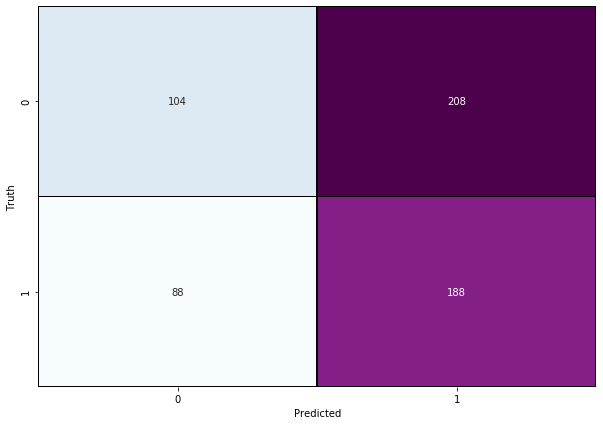

In [279]:
# Shows confusion matrix of svm model on test samples of credit card value
# top left = TN, top right = FP, bottom left = FN, bottom right = TP
cm3 = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(10,7))
axis = sns.heatmap(cm3, annot=True, cmap = 'BuPu', linewidths=.5, linecolor = 'black', fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
bottom, top = axis.get_ylim()
axis.set_ylim(bottom + 0.5, top - 0.5)

In [283]:
# Training/Test data split
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2)

In [284]:
# Creates neural network classifier model
nn = Sequential()
nn.add(Dense(20, input_dim=2, activation='relu')) #input layer requires input_dim param
nn.add(Dropout(0.2))
nn.add(Dense(1, activation='sigmoid')) #sigmoid instead of relu for final probability between 0 and 1
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy']) #compile the nn model, adam gradient descent (optimized)
#call the function to fit to the data (training the model)
nn.fit(X_train, y_train, epochs =30, verbose = 2, shuffle=True, validation_data=(X_test, y_test))


Train on 2352 samples, validate on 588 samples
Epoch 1/30
 - 1s - loss: 3.4624 - acc: 0.4936 - val_loss: 0.7537 - val_acc: 0.4966
Epoch 2/30
 - 0s - loss: 3.1206 - acc: 0.5034 - val_loss: 0.7523 - val_acc: 0.5255
Epoch 3/30
 - 0s - loss: 2.6711 - acc: 0.5153 - val_loss: 0.7360 - val_acc: 0.4898
Epoch 4/30
 - 0s - loss: 2.4096 - acc: 0.4949 - val_loss: 0.7194 - val_acc: 0.5255
Epoch 5/30
 - 0s - loss: 2.0949 - acc: 0.4902 - val_loss: 0.6983 - val_acc: 0.5323
Epoch 6/30
 - 0s - loss: 1.6691 - acc: 0.5128 - val_loss: 0.7133 - val_acc: 0.5238
Epoch 7/30
 - 0s - loss: 1.4299 - acc: 0.5004 - val_loss: 0.6980 - val_acc: 0.5068
Epoch 8/30
 - 0s - loss: 1.2173 - acc: 0.5200 - val_loss: 0.7007 - val_acc: 0.5085
Epoch 9/30
 - 0s - loss: 1.0735 - acc: 0.4830 - val_loss: 0.7055 - val_acc: 0.4745
Epoch 10/30
 - 0s - loss: 0.8967 - acc: 0.4936 - val_loss: 0.7024 - val_acc: 0.4898
Epoch 11/30
 - 0s - loss: 0.8250 - acc: 0.5030 - val_loss: 0.7014 - val_acc: 0.4592
Epoch 12/30
 - 0s - loss: 0.7650 - acc

In [285]:
# Accuracy breakdown
nn_pred = nn.predict(X_test)
print(classification_report(y_test, nn_pred.round()))

              precision    recall  f1-score   support

           0       0.57      0.04      0.07       309
           1       0.48      0.97      0.64       279

    accuracy                           0.48       588
   macro avg       0.52      0.50      0.36       588
weighted avg       0.53      0.48      0.34       588



(2.0, 0.0)

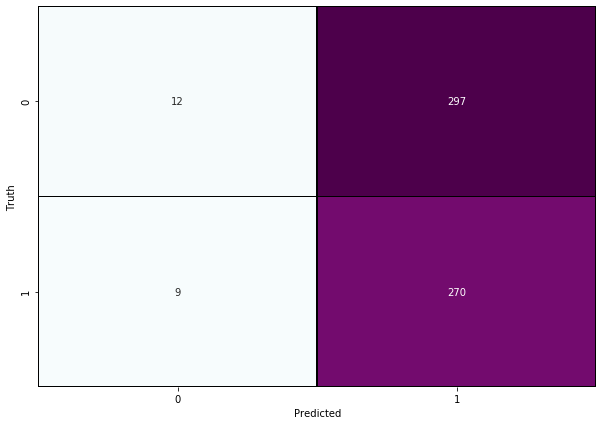

In [286]:
# Shows confusion matrix of nn model on test samples of credit card value
# top left = TN, top right = FP, bottom left = FN, bottom right = TP
cm4 = confusion_matrix(y_test, nn_pred.round())
plt.figure(figsize=(10,7))
axis = sns.heatmap(cm4, annot=True, cmap = 'BuPu', linewidths=.5, linecolor = 'black', fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
bottom, top = axis.get_ylim()
axis.set_ylim(bottom + 0.5, top - 0.5)